In [1]:
from google.colab import drive
drive.mount('/content/drive') #, force_remount=True)

Mounted at /content/drive


In [2]:
imgsz = 800
epoch_num = 100
batch = 16
initial_model_name = "yolov8s"

In [3]:
import os
from datetime import datetime

drive_folder = "/content/drive/MyDrive/trabajo_final_CEIA/train_models"

model_name = "yolov8"

folder_name = f"model_yolov8_tf_{initial_model_name}_imgsz_{imgsz}_epochs_{epoch_num}_batch_{batch}"

In [4]:
# os.makedirs(drive_folder + "/" + model_name + "/" + folder_name)

# print(f"Folder '{folder_name}' created.")

In [5]:
%cd {drive_folder + "/" + model_name + "/" + folder_name}

/content/drive/MyDrive/trabajo_final_CEIA/train_models/yolov8/model_yolov8_tf_yolov8s_imgsz_800_epochs_100_batch_16


In [6]:
dataset_location = drive_folder + "/datasets/" + model_name + "_v2"
dataset_location

'/content/drive/MyDrive/trabajo_final_CEIA/train_models/datasets/yolov8_v2'

In [7]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="PPdsL4UCc8eGcxEw2Tbt")
# project = rf.workspace("saad-salman").project("proj3-hbkyr")
# dataset = project.version(4).download("yolov8", location=dataset_location)

In [8]:
!ls {dataset_location}

data.yaml	    README.roboflow.txt       test   valid
README.dataset.txt  roboflow.zipaykukrtt.tmp  train


In [9]:
%cd {drive_folder + "/" + model_name + "/" + folder_name}

/content/drive/MyDrive/trabajo_final_CEIA/train_models/yolov8/model_yolov8_tf_yolov8s_imgsz_800_epochs_100_batch_16


In [10]:
import os
HOME = os.getcwd()
print(HOME)

/content/drive/MyDrive/trabajo_final_CEIA/train_models/yolov8/model_yolov8_tf_yolov8s_imgsz_800_epochs_100_batch_16


In [11]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.145 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.2/78.2 GB disk)


In [12]:
from ultralytics import YOLO

from IPython.display import display, Image

In [13]:
# !yolo cfg

In [14]:
!cat {dataset_location}/data.yaml

names:
- gun
nc: 1
roboflow:
  license: CC BY 4.0
  project: proj3-hbkyr
  url: https://universe.roboflow.com/saad-salman/proj3-hbkyr/dataset/4
  version: 4
  workspace: saad-salman
test: /content/drive/MyDrive/trabajo_final_CEIA/train_models/datasets/yolov8_v2/test/images
train: /content/drive/MyDrive/trabajo_final_CEIA/train_models/datasets/yolov8_v2/train/images
val: /content/drive/MyDrive/trabajo_final_CEIA/train_models/datasets/yolov8_v2/valid/images


In [15]:
#!cat runs/detect/train/results.csv

In [16]:
HOME

'/content/drive/MyDrive/trabajo_final_CEIA/train_models/yolov8/model_yolov8_tf_yolov8s_imgsz_800_epochs_100_batch_16'

In [17]:
!ls {HOME}/runs/detect/

best-9.pt


In [18]:
!cat {dataset_location}/data.yaml
dataset_location

names:
- gun
nc: 1
roboflow:
  license: CC BY 4.0
  project: proj3-hbkyr
  url: https://universe.roboflow.com/saad-salman/proj3-hbkyr/dataset/4
  version: 4
  workspace: saad-salman
test: /content/drive/MyDrive/trabajo_final_CEIA/train_models/datasets/yolov8_v2/test/images
train: /content/drive/MyDrive/trabajo_final_CEIA/train_models/datasets/yolov8_v2/train/images
val: /content/drive/MyDrive/trabajo_final_CEIA/train_models/datasets/yolov8_v2/valid/images


'/content/drive/MyDrive/trabajo_final_CEIA/train_models/datasets/yolov8_v2'

In [19]:
dataset_location = drive_folder + "/datasets/" + model_name + "_v2"
dataset_location

'/content/drive/MyDrive/trabajo_final_CEIA/train_models/datasets/yolov8_v2'

In [20]:
!yolo val model={HOME}/runs/detect/best-9.pt data=/content/drive/MyDrive/trabajo_final_CEIA/train_models/datasets/yolov8_v2/data.yaml split=test name=val_with_v2_best9

Ultralytics YOLOv8.0.145 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients
100% 755k/755k [00:00<00:00, 31.6MB/s]
val: Scanning /content/drive/MyDrive/trabajo_final_CEIA/train_models/datasets/yolov8_v2/test/labels.cache... 159 images, 2 backgrounds, 0 corrupt: 100% 159/159 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 10/10 [00:05<00:00,  1.69it/s]
                   all        159        157      0.316     0.0127     0.0126    0.00504
Speed: 5.2ms preprocess, 11.1ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/val_with_v2_best9


In [21]:
!ls runs/detect/

best-9.pt  val_with_v2_best9


In [22]:
!ls runs/detect/val_with_v2_best9

confusion_matrix_normalized.png  PR_curve.png		val_batch1_labels.jpg
confusion_matrix.png		 R_curve.png		val_batch1_pred.jpg
F1_curve.png			 val_batch0_labels.jpg	val_batch2_labels.jpg
P_curve.png			 val_batch0_pred.jpg	val_batch2_pred.jpg


In [23]:
!ls

runs


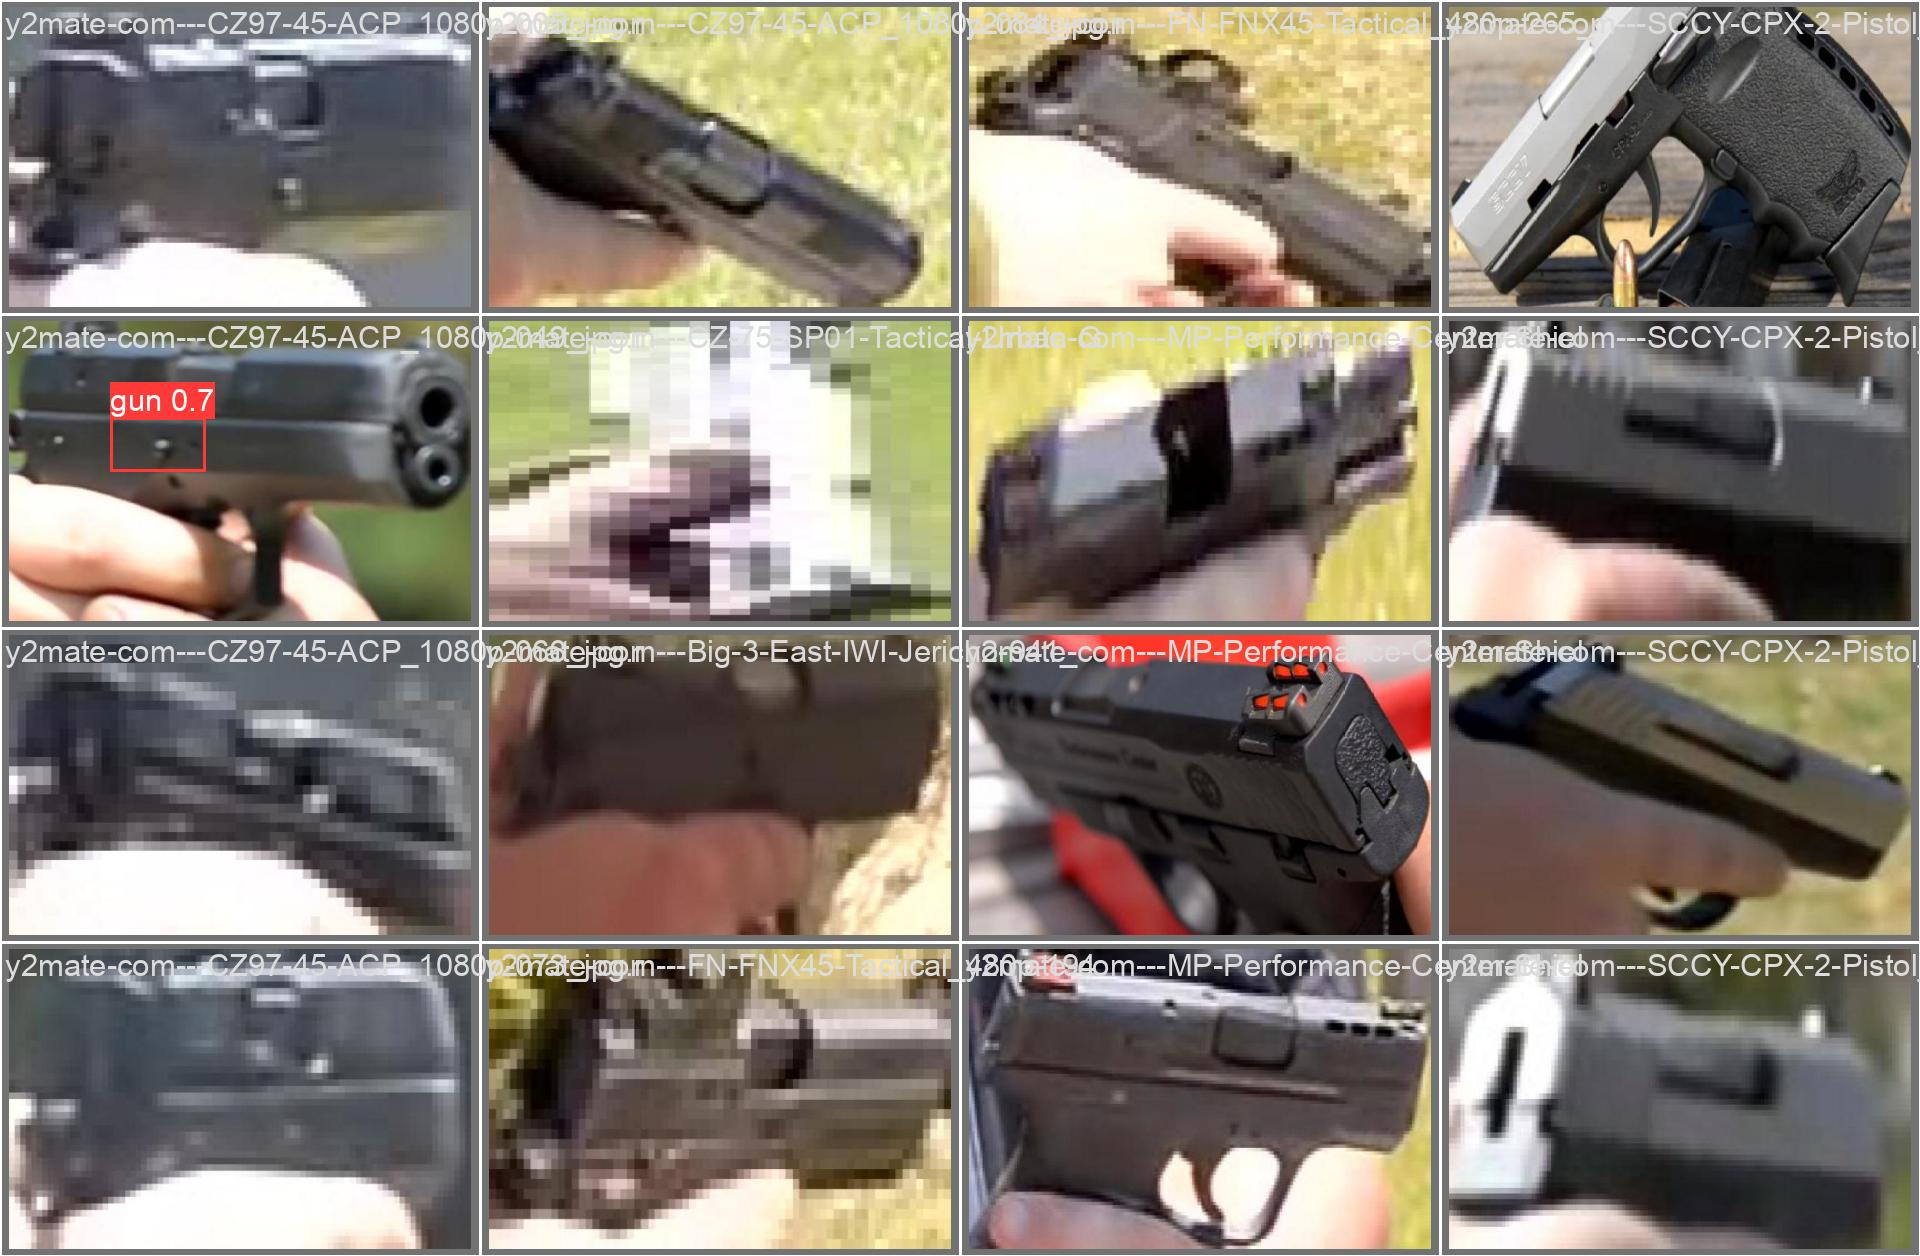

In [24]:
Image(filename='runs/detect/val_with_v2_best9/val_batch2_pred.jpg')

In [25]:
dataset_location = drive_folder + "/datasets/" + model_name + "_test"
dataset_location

'/content/drive/MyDrive/trabajo_final_CEIA/train_models/datasets/yolov8_test'

In [26]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="PPdsL4UCc8eGcxEw2Tbt")
# project = rf.workspace("phillip-lavrador").project("randomized-clips")
# dataset = project.version(1).download("yolov8", location=dataset_location)

In [27]:
!ls {dataset_location}/valid

images	labels	labels.cache


In [28]:
!cat {dataset_location}/data.yaml

names:
- gun
nc: 1
roboflow:
  license: CC BY 4.0
  project: randomized-clips
  url: https://universe.roboflow.com/phillip-lavrador/randomized-clips/dataset/1
  version: 1
  workspace: phillip-lavrador
test: ../test/images
train: /content/drive/MyDrive/trabajo_final_CEIA/train_models/datasets/yolov8_test/train/images
val: /content/drive/MyDrive/trabajo_final_CEIA/train_models/datasets/yolov8_test/valid/images


In [29]:
dataset_location

'/content/drive/MyDrive/trabajo_final_CEIA/train_models/datasets/yolov8_test'

In [30]:
!yolo val model={HOME}/runs/detect/best-9.pt data={dataset_location}/data.yaml split=val name=val_with_v2_best9

Ultralytics YOLOv8.0.145 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients
val: Scanning /content/drive/MyDrive/trabajo_final_CEIA/train_models/datasets/yolov8_test/valid/labels.cache... 1339 images, 575 backgrounds, 0 corrupt: 100% 1339/1339 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 84/84 [01:19<00:00,  1.05it/s]
                   all       1339        788       0.91      0.935      0.946       0.57
Speed: 0.4ms preprocess, 7.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val_with_v2_best92


In [31]:
!ls runs/detect/val_with_v2_best92

confusion_matrix_normalized.png  PR_curve.png		val_batch1_labels.jpg
confusion_matrix.png		 R_curve.png		val_batch1_pred.jpg
F1_curve.png			 val_batch0_labels.jpg	val_batch2_labels.jpg
P_curve.png			 val_batch0_pred.jpg	val_batch2_pred.jpg


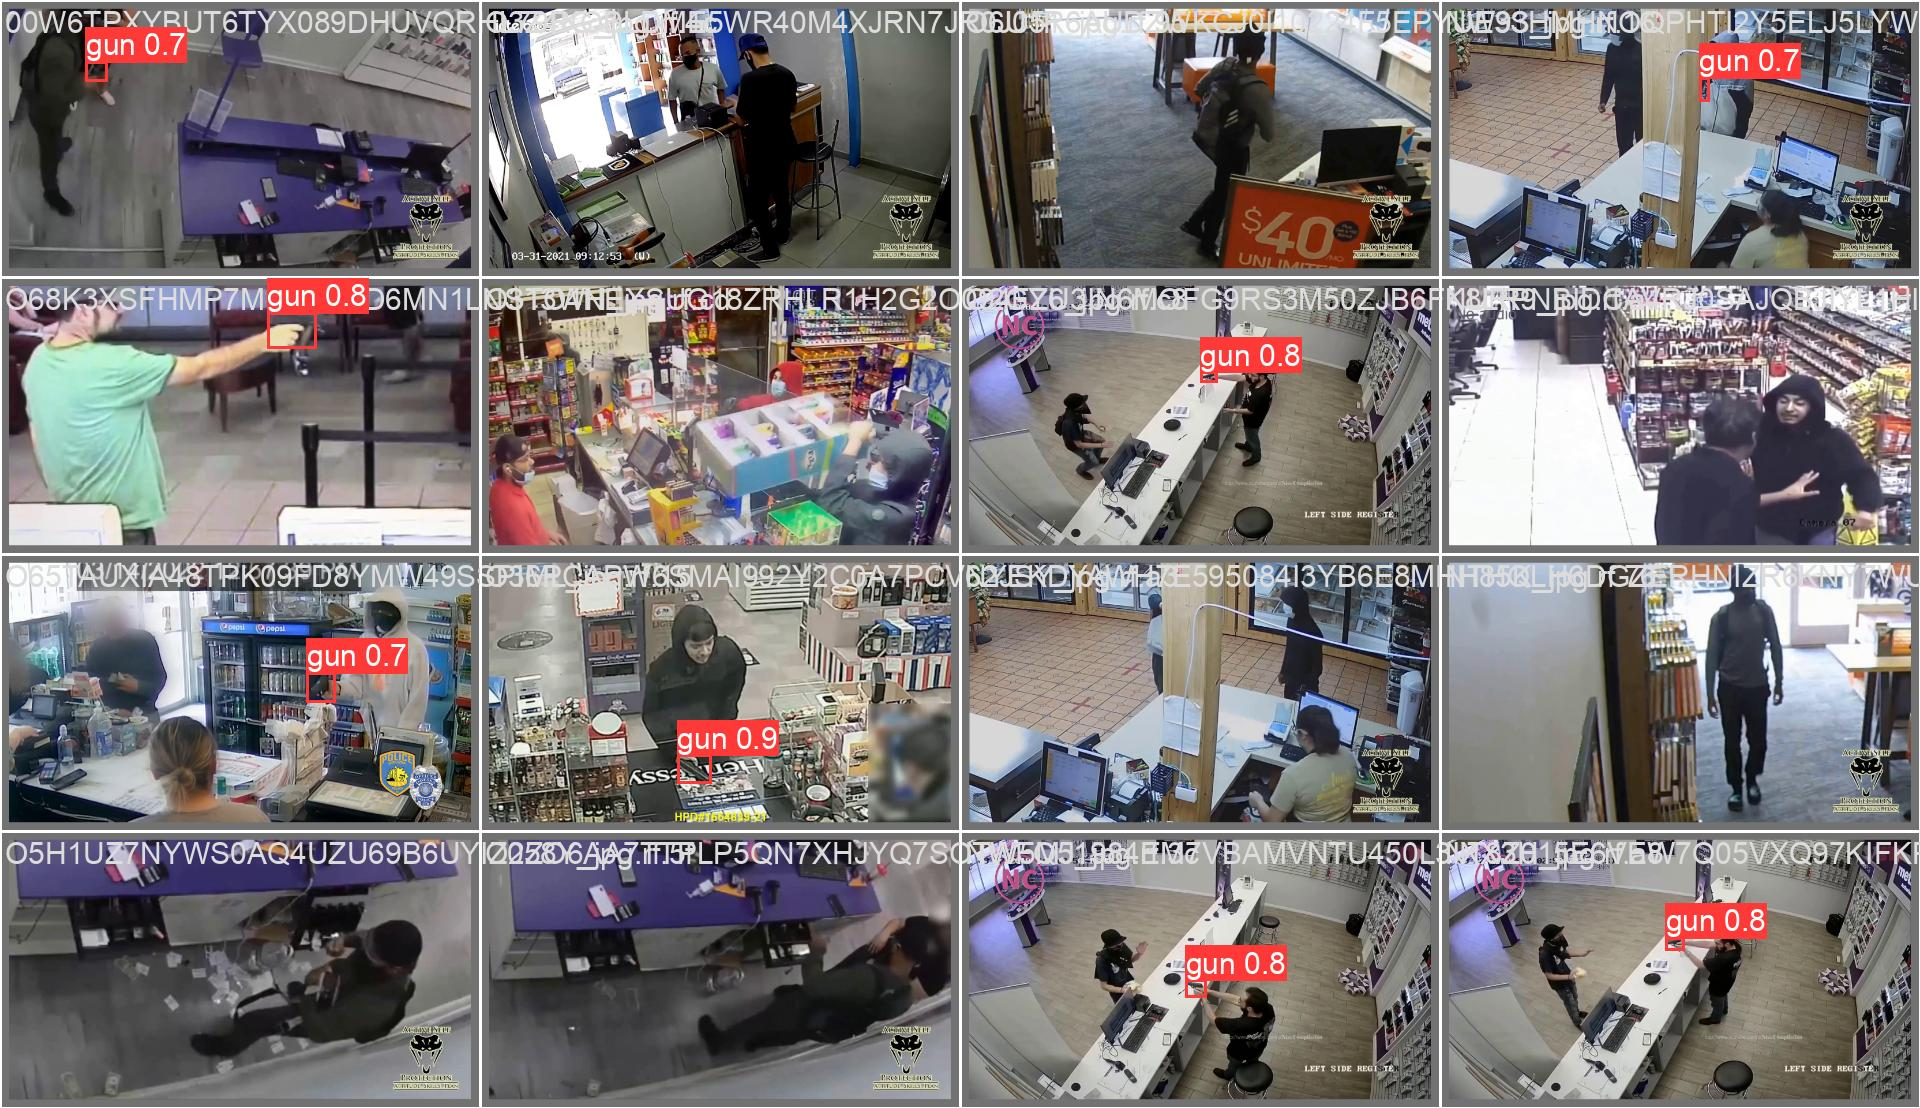

In [32]:
Image(filename='runs/detect/val_with_v2_best92/val_batch0_pred.jpg')

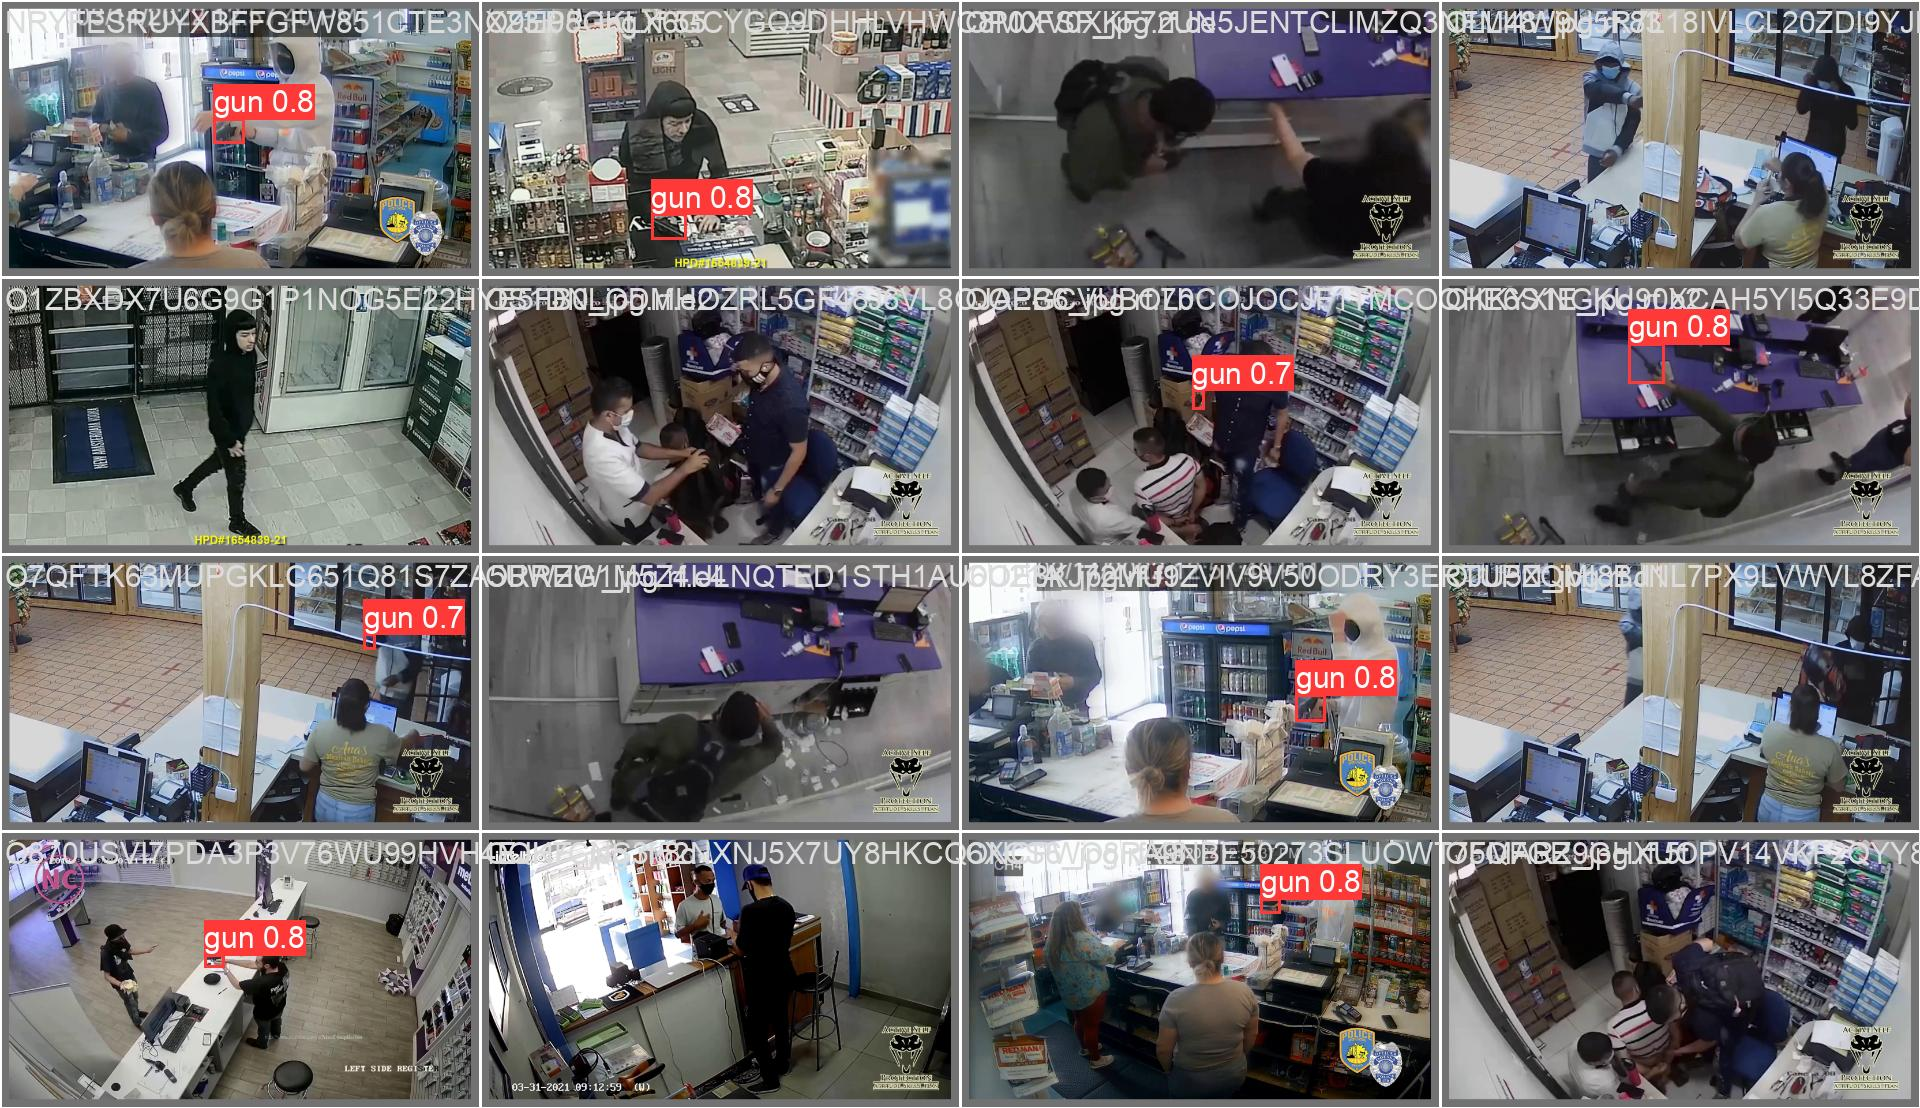

In [33]:
Image(filename='runs/detect/val_with_v2_best92/val_batch1_pred.jpg')

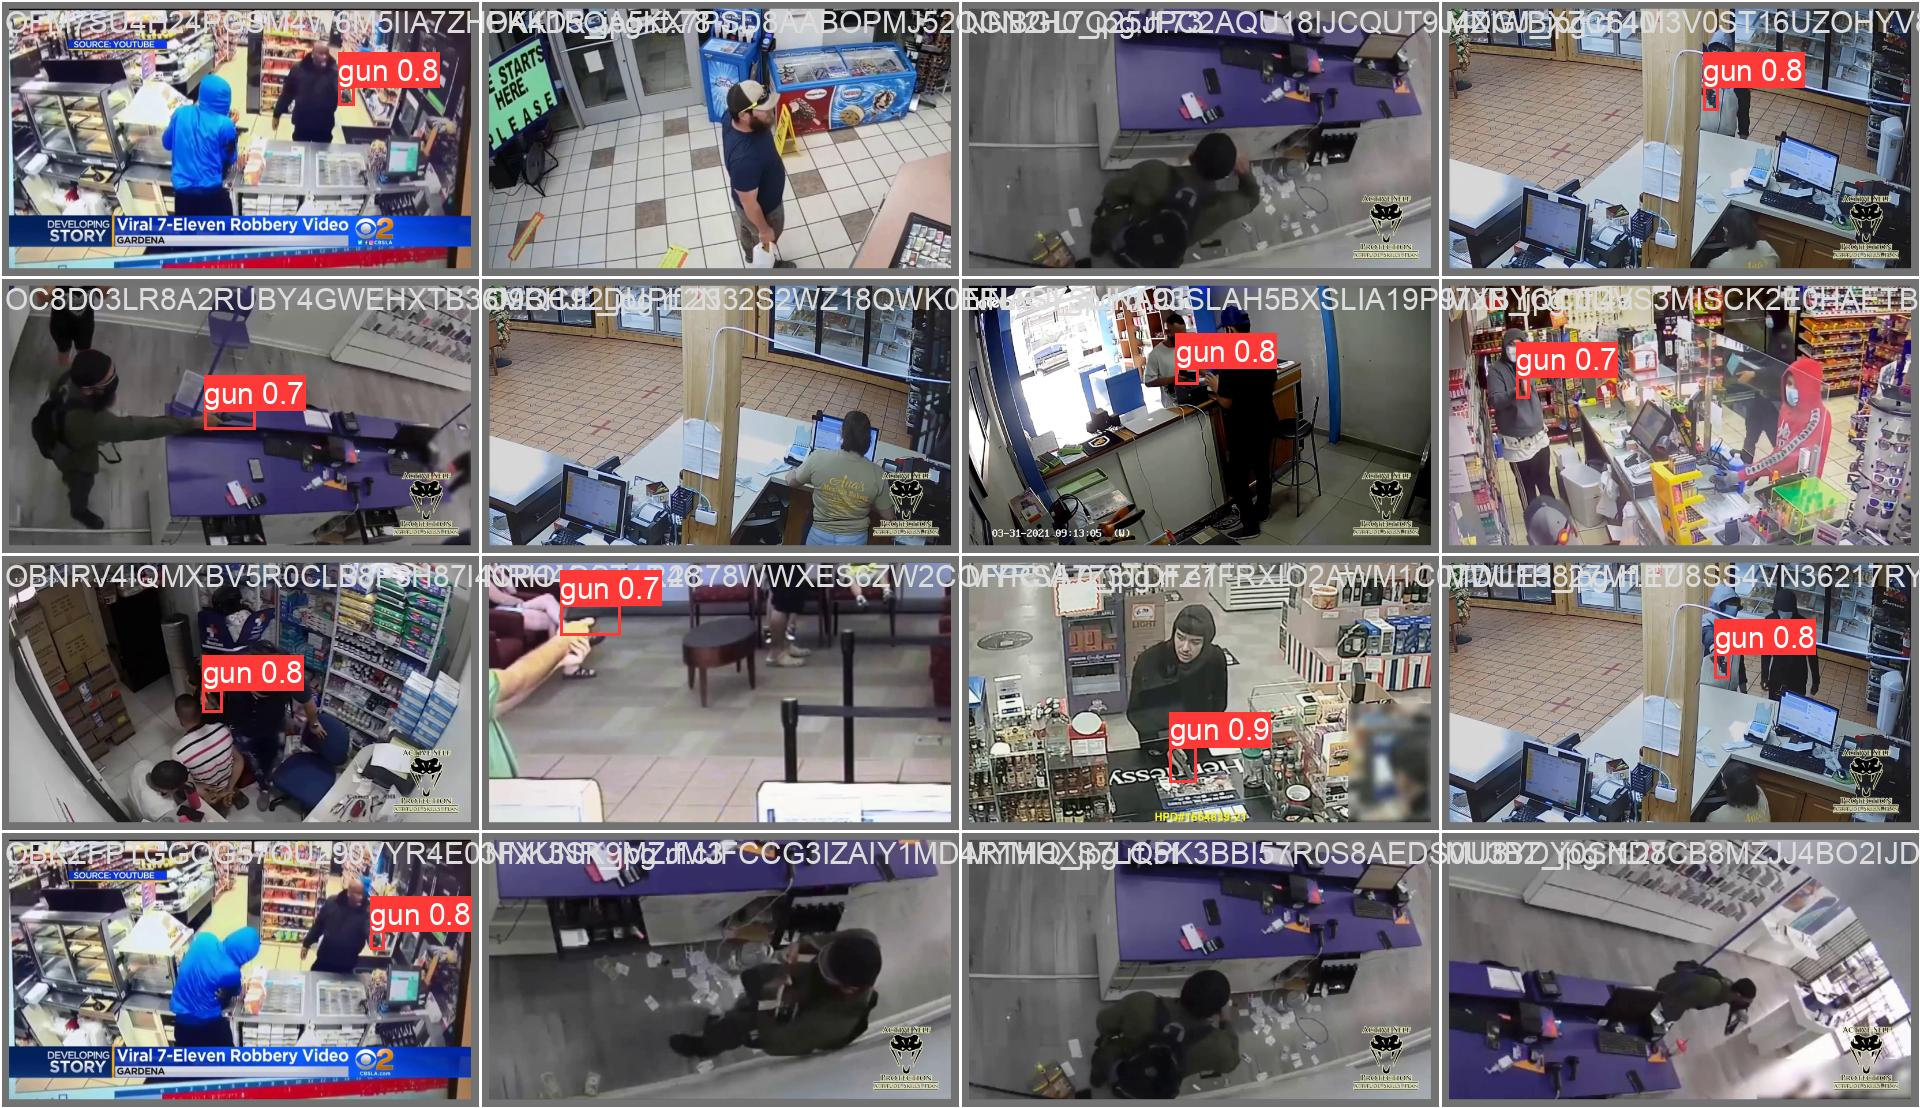

In [34]:
Image(filename='runs/detect/val_with_v2_best92/val_batch2_pred.jpg')
